In [ ]:
// References: 
//   https://www.tensorflow.org/swift/tutorials/a_swift_tour
//   https://github.com/tensorflow/swift-models
//   https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough (Python)
//   https://www.tensorflow.org/swift/tutorials/model_training_walkthrough (Swift)

# Model training walkthrough
 Run in Google Colab
View source on GitHub
This guide introduces Swift for TensorFlow by building a machine learning model that categorizes iris flowers by species. It uses Swift for TensorFlow to: 1. Build a model, 2. Train this model on example data, and 3. Use the model to make predictions about unknown data.

## TensorFlow programming
This guide uses these high-level Swift for TensorFlow concepts:

Import data with the Datasets API.
Build models using Swift abstractions.
Use Python libraries using Swift's Python interoperability when pure Swift libraries are not available.
This tutorial is structured like many TensorFlow programs:

Import and parse the data sets.
Select the type of model.
Train the model.
Evaluate the model's effectiveness.
Use the trained model to make predictions.

# Setup program

Configure imports
Import TensorFlow and some useful Python modules.

In [2]:
import TensorFlow

import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")

In [9]:
// Download a helper file that helps us work around some temporary limitations
// in the dataset API.
import Foundation
import FoundationNetworking
func download(from sourceString: String, to destinationString: String) {
    let source = URL(string: sourceString)!
    let destination = URL(fileURLWithPath: destinationString)
    let data = try! Data.init(contentsOf: source)
    try! data.write(to: destination)
}
download(
    from: "https://raw.githubusercontent.com/tensorflow/swift/master/docs/site/tutorials/TutorialDatasetCSVAPI.swift",
    to: "TutorialDatasetCSVAPI.swift")

# The iris classification problem
Imagine you are a botanist seeking an automated way to categorize each iris flower you find. Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify iris flowers based on the length and width measurements of their sepals and petals.

The Iris genus entails about 300 species, but our program will only classify the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor
Figure 1. Iris setosa (by Radomil, CC BY-SA 3.0), Iris versicolor, (by Dlanglois, CC BY-SA 3.0), and Iris virginica (by Frank Mayfield, CC BY-SA 2.0).
 
Fortunately, someone has already created a data set of 120 iris flowers with the sepal and petal measurements. This is a classic dataset that is popular for beginner machine learning classification problems.

# Import and parse the training dataset
Download the dataset file and convert it into a structure that can be used by this Swift program.

# Download the dataset
Download the training dataset file from http://download.tensorflow.org/data/iris_training.csv.

In [10]:
let trainDataFilename = "iris_training.csv"
download(from: "http://download.tensorflow.org/data/iris_training.csv", to: trainDataFilename)

# Inspect the data

This dataset, iris_training.csv, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Let's look a the first 5 entries.

In [11]:
let f = Python.open(trainDataFilename)
for _ in 0..<5 {
    print(Python.next(f).strip())
}
f.close()

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


None


# From this view of the dataset, notice the following:

1. The first line is a header containing information about the dataset:
       * There are 120 total examples. Each example has four features and one of three possible label names.
2. Subsequent rows are data records, one example per line, where:
       * The first four fields are features: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
       * The last column is the label: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

Let's write that out in code:

In [ ]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* 0: Iris setosa
* 1: Iris versicolor
* 2: Iris virginica

For more information about features and labels, see the ML Terminology section of the Machine Learning Crash Course.


In [13]:
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

# Create a Dataset

Swift for TensorFlow's Dataset API is a high-level API for reading data and transforming it into a form used for training.

Eventually, the Dataset API will be able to load data from many file formats. The Dataset API is currently very incomplete, so we include some glue code from "TutorialDatasetCSVAPI.swift" that helps the Dataset API load data from the CSV file into the IrisBatch struct.

In [14]:
let batchSize = 32

/// A batch of examples from the iris dataset.
struct IrisBatch {
    /// [batchSize, featureCount] tensor of features.
    let features: Tensor<Float>

    /// [batchSize] tensor of labels.
    let labels: Tensor<Int32>
}

%include "TutorialDatasetCSVAPI.swift"

let trainDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: trainDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

The Dataset<IrisBatch> is a sequence of IrisBatches. Let's look at the first element of the dataset.

In [15]:
let firstTrainExamples = trainDataset.first!
let firstTrainFeatures = firstTrainExamples.features
let firstTrainLabels = firstTrainExamples.labels
print("First batch of features: \(firstTrainFeatures)")
print("First batch of labels: \(firstTrainLabels)")

First batch of features: [[6.4, 2.8, 5.6, 2.2],
 [5.0, 2.3, 3.3, 1.0],
 [4.9, 2.5, 4.5, 1.7],
 [4.9, 3.1, 1.5, 0.1],
 [5.7, 3.8, 1.7, 0.3],
 [4.4, 3.2, 1.3, 0.2],
 [5.4, 3.4, 1.5, 0.4],
 [6.9, 3.1, 5.1, 2.3],
 [6.7, 3.1, 4.4, 1.4],
 [5.1, 3.7, 1.5, 0.4],
 [5.2, 2.7, 3.9, 1.4],
 [6.9, 3.1, 4.9, 1.5],
 [5.8, 4.0, 1.2, 0.2],
 [5.4, 3.9, 1.7, 0.4],
 [7.7, 3.8, 6.7, 2.2],
 [6.3, 3.3, 4.7, 1.6],
 [6.8, 3.2, 5.9, 2.3],
 [7.6, 3.0, 6.6, 2.1],
 [6.4, 3.2, 5.3, 2.3],
 [5.7, 4.4, 1.5, 0.4],
 [6.7, 3.3, 5.7, 2.1],
 [6.4, 2.8, 5.6, 2.1],
 [5.4, 3.9, 1.3, 0.4],
 [6.1, 2.6, 5.6, 1.4],
 [7.2, 3.0, 5.8, 1.6],
 [5.2, 3.5, 1.5, 0.2],
 [5.8, 2.6, 4.0, 1.2],
 [5.9, 3.0, 5.1, 1.8],
 [5.4, 3.0, 4.5, 1.5],
 [6.7, 3.0, 5.0, 1.7],
 [6.3, 2.3, 4.4, 1.3],
 [5.1, 2.5, 3.0, 1.1]]
First batch of labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


# 
Notice that the features for the first batchSize examples are grouped together (or batched) into firstTrainFeatures, and that the labels for the first batchSize examples are batched into firstTrainLabels.

You can start to see some clusters by plotting a few features from the batch, using Python's matplotlib:

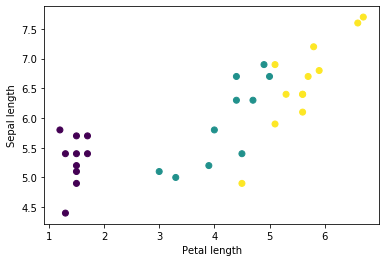

None


In [16]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()
let petalLengths = firstTrainFeaturesTransposed[2].scalars
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [17]:
import TensorFlow

let hiddenSize: Int = 10
struct IrisModel: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = IrisModel()

In [23]:
// Apply the model to a batch of features.
let firstTrainPredictions = model(firstTrainFeatures)
firstTrainPredictions[0..<5]

[[  -0.4495951,   -0.4306218,    -0.324744],
 [  -0.5219424,  -0.35435325,  -0.14070773],
 [ -0.48763084,    -0.408302,   -0.3121065],
 [  -1.1656637,  -0.46056813, -0.033667713],
 [  -1.3748541,  -0.54683363,  -0.12533998]]


In [24]:
firstTrainLabels[0..<5]

[2, 1, 2, 0, 0]


In [25]:
softmax(firstTrainPredictions[0..<5])

[[0.31724536, 0.32332203, 0.35943258],
 [0.27423245,  0.3242663, 0.40150127],
 [0.30539656, 0.33061016,  0.3639933],
 [ 0.1632418, 0.33040795,  0.5063502],
 [0.14754854, 0.33770666,  0.5147448]]


In [26]:
print("Prediction: \(firstTrainPredictions.argmax(squeezingAxis: 1))")
print("    Labels: \(firstTrainLabels)")

Prediction: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
    Labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


In [27]:
let untrainedLogits = model(firstTrainFeatures)
let untrainedLoss = softmaxCrossEntropy(logits: untrainedLogits, labels: firstTrainLabels)
print("Loss test: \(untrainedLoss)")

Loss test: 1.3017917


In [28]:
let optimizer = SGD(for: model, learningRate: 0.01)

In [29]:
let (loss, grads) = model.valueWithGradient { model -> Tensor<Float> in
    let logits = model(firstTrainFeatures)
    return softmaxCrossEntropy(logits: logits, labels: firstTrainLabels)
}
print("Current loss: \(loss)")

Current loss: 1.3017917


In [30]:
optimizer.update(&model.allDifferentiableVariables, along: grads)

In [31]:
let logitsAfterOneStep = model(firstTrainFeatures)
let lossAfterOneStep = softmaxCrossEntropy(logits: logitsAfterOneStep, labels: firstTrainLabels)
print("Next loss: \(lossAfterOneStep)")

Next loss: 1.2653543


In [ ]:
// As you can see step-27, then step-30 (Gradient optimizer update), then step-31 shows improvement

# Training loop
With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

Iterate each epoch. An epoch is one pass through the dataset.
Within an epoch, iterate over each example in the training Dataset grabbing its features (x) and label (y).
Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
Use gradient descent to update the model's variables.
Keep track of some stats for visualization.
Repeat for each epoch.
The epochCount variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. epochCount is a hyperparameter that you can tune. Choosing the right number usually requires both experience and experimentation.

In [32]:
let epochCount = 500
var trainAccuracyResults: [Float] = []
var trainLossResults: [Float] = []

In [33]:
func accuracy(predictions: Tensor<Int32>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions .== truths).mean().scalarized()
}

for epoch in 1...epochCount {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for batch in trainDataset {
        let (loss, grad) = model.valueWithGradient { (model: IrisModel) -> Tensor<Float> in
            let logits = model(batch.features)
            return softmaxCrossEntropy(logits: logits, labels: batch.labels)
        }
        optimizer.update(&model.allDifferentiableVariables, along: grad)
        
        let logits = model(batch.features)
        epochAccuracy += accuracy(predictions: logits.argmax(squeezingAxis: 1), truths: batch.labels)
        epochLoss += loss.scalarized()
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    if epoch % 50 == 0 {
        print("Epoch \(epoch): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
    }
}

Epoch 50: Loss: 0.5162295, Accuracy: 0.6979167
Epoch 100: Loss: 0.36855054, Accuracy: 0.9296875
Epoch 150: Loss: 0.27040628, Accuracy: 0.9609375
Epoch 200: Loss: 0.20175269, Accuracy: 0.96875
Epoch 250: Loss: 0.16146436, Accuracy: 0.9765625
Epoch 300: Loss: 0.13766076, Accuracy: 0.9765625
Epoch 350: Loss: 0.122409485, Accuracy: 0.9765625
Epoch 400: Loss: 0.112047486, Accuracy: 0.9765625
Epoch 450: Loss: 0.10462641, Accuracy: 0.9765625
Epoch 500: Loss: 0.09910211, Accuracy: 0.984375


# Visualize the loss function over time
While it's helpful to print out the model's training progress, it's often more helpful to see this progress. We can create basic charts using Python's matplotlib module.

Interpreting these charts takes some experience, but you really want to see the loss go down and the accuracy go up.

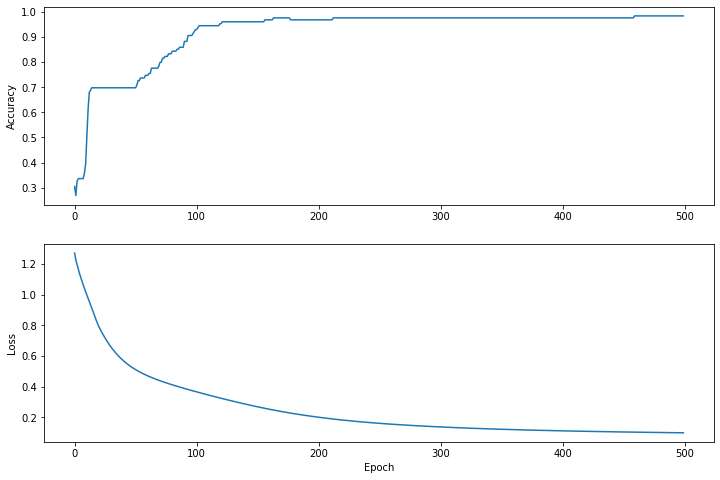

None


In [34]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Accuracy")
accuracyAxes.plot(trainAccuracyResults)

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Loss")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(trainLossResults)

plt.show()

# Evaluate the model's effectiveness
Now that the model is trained, we can get some statistics on its performance.

Evaluating means determining how effectively the model makes predictions. To determine the model's effectiveness at iris classification, pass some sepal and petal measurements to the model and ask the model to predict what iris species they represent. Then compare the model's prediction against the actual label. For example, a model that picked the correct species on half the input examples has an accuracy of 0.5. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

Example features	Label	Model prediction
5.9	3.0	4.3	1.5	1	1
6.9	3.1	5.4	2.1	2	2
5.1	3.3	1.7	0.5	0	0
6.0	3.4	4.5	1.6	1	2
5.5	2.5	4.0	1.3	1	1
Figure 4. An iris classifier that is 80% accurate.
 
Setup the test dataset
Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate test set rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test Dataset is similar to the setup for training Dataset. Download the test set from http://download.tensorflow.org/data/iris_test.csv:

In [35]:
let testDataFilename = "iris_test.csv"
download(from: "http://download.tensorflow.org/data/iris_test.csv", to: testDataFilename)

In [37]:
let f = Python.open(testDataFilename)
for _ in 0..<5 {
    print(Python.next(f).strip())
}
f.close()

30,4,setosa,versicolor,virginica
5.9,3.0,4.2,1.5,1
6.9,3.1,5.4,2.1,2
5.1,3.3,1.7,0.5,0
6.0,3.4,4.5,1.6,1


None


# Now load it into a Dataset:

In [36]:
let testDataset: Dataset<IrisBatch> = Dataset(
    contentsOfCSVFile: testDataFilename, hasHeader: true,
    featureColumns: [0, 1, 2, 3], labelColumns: [4]
).batched(batchSize)

# Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single epoch of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [38]:
// NOTE: With `batchSize = 32` and 30 examples in the test dataset, only one batch will run in the loop.
for testBatch in testDataset {
    let logits = model(testBatch.features)
    let predictions = logits.argmax(squeezingAxis: 1)
    print("Test batch accuracy: \(accuracy(predictions: predictions, truths: testBatch.labels))")
}

Test batch accuracy: 0.93333334


In [39]:
let firstTestBatch = testDataset.first!
let firstTestBatchLogits = model(firstTestBatch.features)
let firstTestBatchPredictions = firstTestBatchLogits.argmax(squeezingAxis: 1)

print(firstTestBatchPredictions)
print(firstTestBatch.labels)

[1, 2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1]
[1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]


# Use the trained model to make predictions

We've trained a model and demonstrated that it's good—but not perfect—at classifying iris species. Now let's use the trained model to make some predictions on unlabeled examples; that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

0: Iris setosa
1: Iris versicolor
2: Iris virginica

In [40]:
let unlabeledDataset: Tensor<Float> =
    [[5.1, 3.3, 1.7, 0.5],
     [5.9, 3.0, 4.2, 1.5],
     [6.9, 3.1, 5.4, 2.1]]

let unlabeledDatasetPredictions = model(unlabeledDataset)

for i in 0..<unlabeledDatasetPredictions.shape[0] {
    let logits = unlabeledDatasetPredictions[i]
    let classIdx = logits.argmax().scalar!
    print("Example \(i) prediction: \(classNames[Int(classIdx)]) (\(softmax(logits)))")
}

Example 0 prediction: Iris setosa ([    0.9936847,  0.0063153044, 4.2311807e-11])
Example 1 prediction: Iris versicolor ([0.0013541785,    0.9887306,  0.009915232])
Example 2 prediction: Iris virginica ([1.028563e-06,   0.15689576,   0.84310323])
